# Reference

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from modelbase.ode import Model, LabelModel, LinearLabelModel, Simulator, mca
from modelbase.ode import ratefunctions as rf

## ODE models

### Basic models

Let's start with a linear reaction chain 

$$\require{mhchem}
\ce{->[v0] X <->[v1] Y ->[v2]}
$$

with constant influx

$$v_0 = k_0$$

one reaction with reversible michaelis-menten kinetics

$$v_1 = k_1^+ X - k_1^- Y$$

and irreversible mass-action outflux

$$v_2 = k_2 Y$$

which gives us the following system of ODEs

$$\begin{align}
\frac{d}{dt} X &= v_0 - v_1 \\
\frac{d}{dt} Y &= v_1 - v_2 \\
\end{align}$$

In [2]:
def constant(k):
    return k


def mass_action_1s(s, kp):
    """Irreversible mass-action function with 1 substrate"""
    return kp * s


def mass_action_1s_1p(s, p, kp, km):
    """Reversible mass-action function with 1 substrate and 1 product"""
    return kp * s - km * p

In [3]:
m = Model()
m.add_parameters({"k0": 1, "k1p": 0.5, "k1m": 1, "k2": 0.1})
m.add_compounds(["X", "Y"])

m.add_reaction(
    rate_name="v0",
    function=constant,
    stoichiometry={"X": 1},
    parameters=["k0"],
)
m.add_reaction(
    rate_name="v1",
    function=mass_action_1s_1p,
    stoichiometry={"X": -1, "Y": 1},
    parameters=["k1p", "k1m"],
    reversible=True,
)
m.add_reaction(
    rate_name="v2",
    function=mass_action_1s,
    stoichiometry={"Y": -1},
    parameters=["k2"],
)

First check the stoichiometric matrix to see that we assembled our system correctly

In [7]:
m.get_stoichiometric_df()

v0   v1   v2
X  1.0 -1.0  0.0
Y  0.0  1.0 -1.0

Now that everything is ready, let's simulate the model

In [10]:
s = Simulator(m)
s.initialise({"X": 0, "Y": 0})
t, y = s.simulate(10000)
fig, ax = s.plot(xlabel="Time [au]", ylabel="Concentration [au]")
plt.show()

It seems like the system is going into a steady state. Let's find out where it is

In [6]:
_, y_ss = s.simulate_to_steady_state()
y_ss

array([[22.00000002, 10.00000001]])

How would that steady state change if we change the influx of the system?

In [11]:
y_ss = s.parameter_scan(
    parameter_name="k0",
    parameter_values=np.linspace(0, 10, 11),
)
y_ss

  0%|          | 0/11 [00:00<?, ?it/s]

X      Y
0.0     0.0    0.0
1.0    22.0   10.0
2.0    44.0   20.0
3.0    66.0   30.0
4.0    88.0   40.0
5.0   110.0   50.0
6.0   132.0   60.0
7.0   154.0   70.0
8.0   176.0   80.0
9.0   198.0   90.0
10.0  220.0  100.0

Numbers aren't that fun to look at. Let's use the fact that our output is a nice pandas DataFrame to directly produce a small plot.

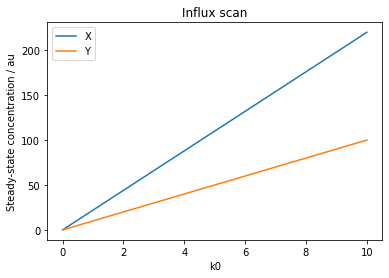

In [8]:
ax = y_ss.plot(
    xlabel="k0",
    ylabel="Steady-state concentration / au",
    title="Influx scan",
)
ax.legend()
plt.show()

#### Alternative ways of writing the same model

In [9]:
m = Model()
m.add_parameters({"k0": 1, "k1p": 0.5, "k1m": 1, "k2": 0.1})
m.add_compounds(["X", "Y"])

m.add_rate(
    rate_name="v0",
    function=rf.constant,
    parameters=["k0"],
)
m.add_rate(
    rate_name="v1",
    function=rf.reversible_mass_action_1_1,
    substrates=["X"],
    products=["Y"],
    parameters=["k1p", "k1m"],
    reversible=True,
)
m.add_rate(
    rate_name="v2",
    function=rf.mass_action_1,
    substrates=["Y"],
    parameters=["k2"],
)

m.add_stoichiometries(
    {
        "v0": {"X": 1},
        "v1": {"X": -1, "Y": 1},
        "v2": {"Y": -1},
    }
)

In [10]:
m = Model()
m.add_parameters({"k0": 1, "k1p": 0.5, "k1m": 1, "k2": 0.1})
m.add_compounds(["X", "Y"])

m.add_rate(
    rate_name="v0",
    function=rf.constant,
    parameters=["k0"],
)
m.add_rate(
    rate_name="v1",
    function=rf.reversible_mass_action_1_1,
    substrates=["X"],
    products=["Y"],
    parameters=["k1p", "k1m"],
    reversible=True,
)
m.add_rate(
    rate_name="v2",
    function=rf.mass_action_1,
    substrates=["Y"],
    parameters=["k2"],
)

m.add_stoichiometries_by_compounds(
    {
        "X": {"v0": 1, "v1": -1},
        "Y": {"v1": 1, "v2": -1},
    }
)

### Time-dependent external conditions

In [11]:
def time_dependent_influx(time, k):
    return np.exp(-k * time)


m = Model()
m.add_parameters({"l": 1, "k": 0.1})
m.add_compounds(["X"])
m.add_reaction(
    rate_name="v0",
    function=time_dependent_influx,
    stoichiometry={"X": 1},
    modifiers=["time"],
    parameters=["l"],
)
m.add_reaction(
    rate_name="v1",
    function=rf.mass_action_1,
    stoichiometry={"X": -1},
    parameters=["k"],
)

s = Simulator(m)
s.initialise({"X": 0})
t, y = s.simulate(50)
fig, ax = s.plot(
    xlabel="Time [au]",
    ylabel="Concentration [au]",
    title="Time-dependent influx",
)
plt.show()

### Algebraic modules

These can be used for rapidly changing variables, such as

- moieties: ADP + ATP = AP_total

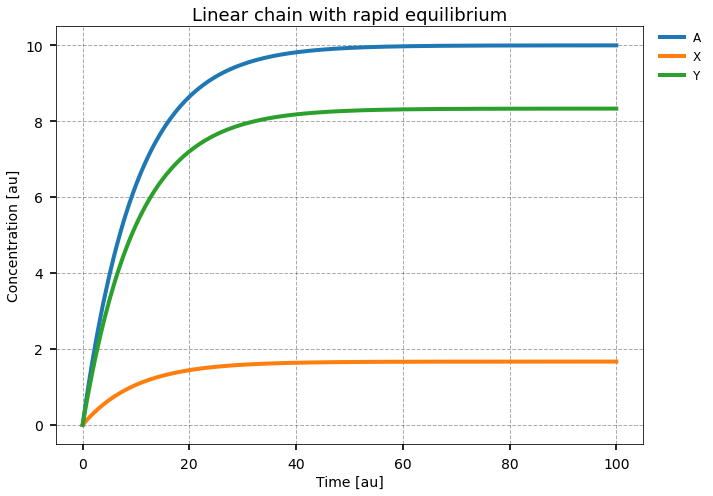

In [12]:
def rapid_equilibrium(substrate, k_eq):
    x = substrate / (1 + k_eq)
    y = substrate * k_eq / (1 + k_eq)
    return x, y


p = {"k0": 1, "k2": 0.1, "K": 5}
m = Model(p)
m.add_compounds(["A"])

m.add_algebraic_module(
    module_name="fast_eq",
    function=rapid_equilibrium,
    compounds=["A"],
    derived_compounds=["X", "Y"],
    parameters=["K"],
)

m.add_reaction(
    rate_name="v0",
    function=rf.constant,
    stoichiometry={"A": 1},
    parameters=["k0"],
)
m.add_reaction(
    rate_name="v2",
    function=rf.mass_action_1,
    stoichiometry={"A": -1},
    parameters=["k2"],
)

s = Simulator(m)
s.initialise({"A": 0})
s.simulate(100)
fig, ax = s.plot_all(
    xlabel="Time [au]",
    ylabel="Concentration [au]",
    title="Linear chain with rapid equilibrium",
)
plt.show()

### Phase-plane analysis

In [12]:
def v1(s2, K, k1, n):
    return k1 / (1 + (s2 / K) ** n)


pars = {
    "k1": 20,
    "k2": 5,
    "k3": 5,
    "k4": 5,
    "k5": 2,
    "K": 1,
    "n": 4,
}

m = Model(pars)
m.add_compounds(["s1", "s2"])
m.add_rate(
    rate_name="v1",
    function=v1,
    substrates=["s2"],
    parameters=["K", "k1", "n"],
)
m.add_rate(
    rate_name="v2",
    function=rf.constant,
    parameters=["k2"],
)
m.add_rate(
    rate_name="v3",
    function=rf.mass_action_1,
    substrates=["s1"],
    parameters=["k3"],
)
m.add_rate(
    rate_name="v4",
    function=rf.mass_action_1,
    substrates=["s2"],
    parameters=["k4"],
)
m.add_rate(
    rate_name="v5",
    function=rf.mass_action_1,
    substrates=["s1"],
    parameters=["k5"],
)

m.add_stoichiometries_by_compounds(
    {
        "s1": {"v1": 1, "v3": -1, "v5": -1},
        "s2": {"v2": 1, "v5": 1, "v4": -1},
    }
)

s = Simulator(m)
s.initialise([10, 0])
t, y = s.simulate(3)

fig, axs = plt.subplots(1, 2, figsize=(12, 5))
s.plot(ax=axs[0])
s.plot_phase_plane("s1", "s2", ax=axs[1])
fig.tight_layout()
plt.show()

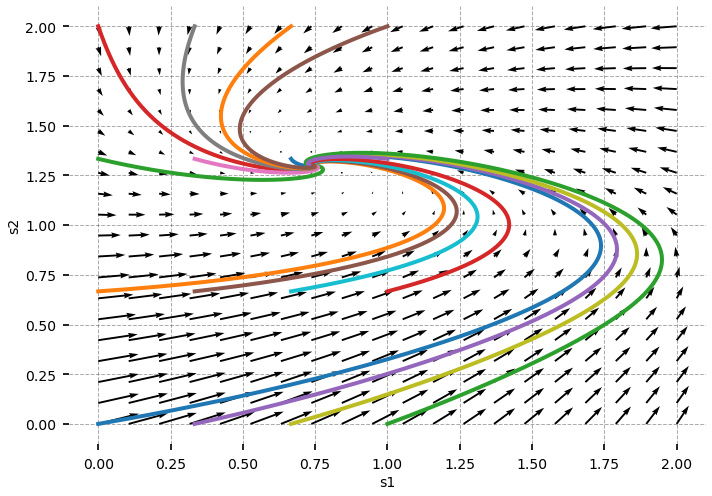

In [14]:
fig, ax = s.plot_trajectories(
    cpd1="s1",
    cpd2="s2",
    y0=[0, 0],
    cpd1_bounds=(0, 2),
    cpd2_bounds=(0, 2),
    n=20,
)

for s1 in np.linspace(0, 1, 4):
    for s2 in np.linspace(0, 2, 4):
        s.initialise([s1, s2])
        t, y = s.simulate(1.5, 1000)
        fig, ax = s.plot_phase_plane("s1", "s2", ax=ax)
fig.tight_layout()
plt.show()

## Isotope-labeled models

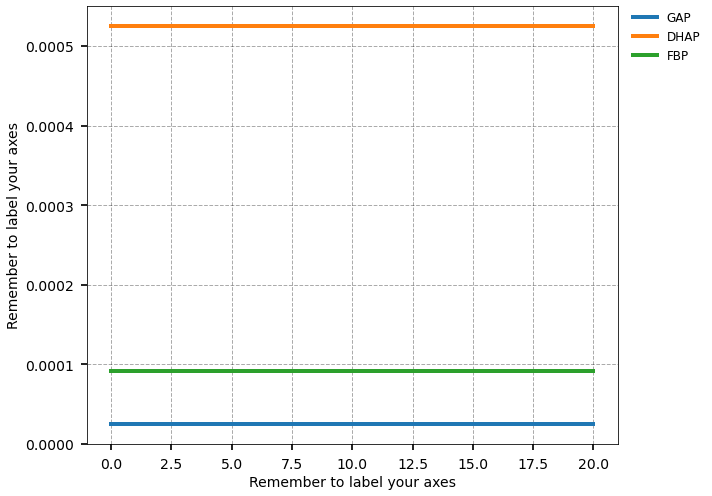

In [15]:
p = {
    "kf_TPI": 1.0,
    "Keq_TPI": 21.0,
    "kf_Ald": 2000.0,
    "Keq_Ald": 7000.0,
}

m = Model(p)
m.add_derived_parameter(
    parameter_name="kr_TPI",
    function=lambda x, y: x / y,
    parameters=["kf_TPI", "Keq_TPI"],
)
m.add_derived_parameter(
    parameter_name="kr_Ald",
    function=lambda x, y: x / y,
    parameters=["kf_Ald", "Keq_Ald"],
)

m.add_compounds(["GAP", "DHAP", "FBP"])
m.add_reaction(
    rate_name="TPIf",
    function=rf.mass_action_1,
    stoichiometry={"GAP": -1, "DHAP": 1},
    parameters=["kf_TPI"],
    reversible=False,
)
m.add_reaction(
    rate_name="TPIr",
    function=rf.mass_action_1,
    stoichiometry={"DHAP": -1, "GAP": 1},
    parameters=["kr_TPI"],
    reversible=False,
)
m.add_reaction(
    rate_name="ALDf",
    function=rf.mass_action_2,
    stoichiometry={"DHAP": -1, "GAP": -1, "FBP": 1},
    parameters=["kf_Ald"],
    reversible=False,
)
m.add_reaction(
    rate_name="ALDr",
    function=rf.mass_action_1,
    stoichiometry={
        "FBP": -1,
        "DHAP": 1,
        "GAP": 1,
    },
    parameters=["kr_Ald"],
    reversible=False,
)

# set initial concentrations
GAP0 = 2.50e-5
DHAP0 = GAP0 * m.parameters["Keq_TPI"]
FBP0 = GAP0 * DHAP0 * m.parameters["Keq_Ald"]
base_y0 = {"GAP": GAP0, "DHAP": DHAP0, "FBP": FBP0}

s = Simulator(m)
s.initialise(base_y0)
t, y = s.simulate(20)
s.plot()
plt.show()

y_ss = base_y0
v_ss = {k: v[0] for k, v in m.get_fluxes_dict(y_ss).items()}

### Linear Label Model

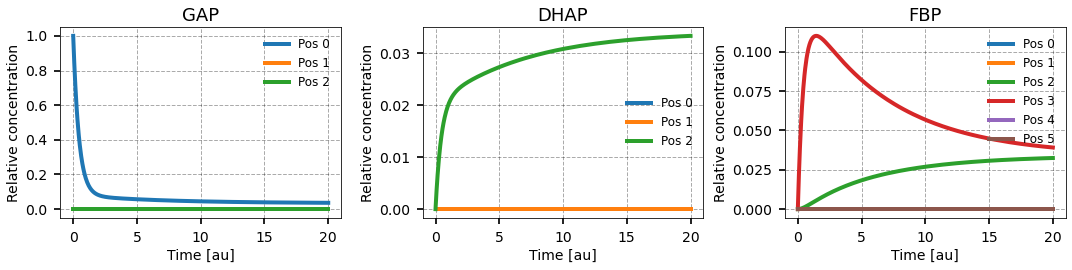

In [16]:
llm = m.to_linear_labelmodel(
    labelcompounds={"GAP": 3, "DHAP": 3, "FBP": 6},
    labelmaps={
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)

y0 = llm.generate_y0(initial_labels={"GAP": 0})

lls = Simulator(llm)
lls.initialise(y0, y_ss, v_ss)
t, y = lls.simulate(20)
fig, ax = lls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"],
    sharey=False,
    xlabels="Time [au]",
)
fig.tight_layout()
plt.show()

### Label Model

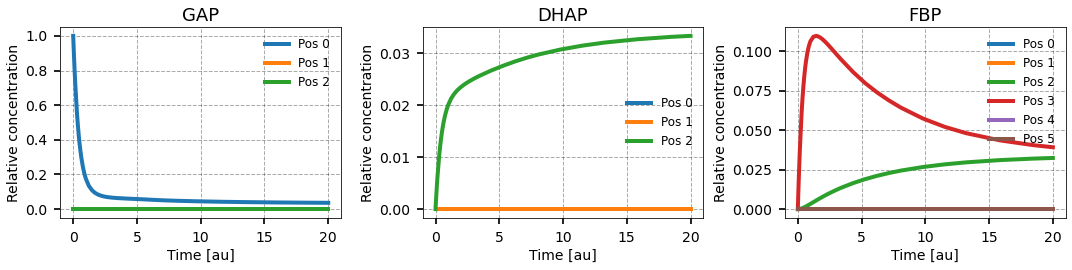

In [17]:
lm = m.to_labelmodel(
    {"GAP": 3, "DHAP": 3, "FBP": 6},
    {
        "TPIf": [2, 1, 0],
        "TPIr": [2, 1, 0],
        "ALDf": [0, 1, 2, 3, 4, 5],
        "ALDr": [0, 1, 2, 3, 4, 5],
    },
)


y0 = lm.generate_y0(base_y0, label_positions={"GAP": 0})
ls = Simulator(lm)
ls.initialise(y0)
t, y = ls.simulate(20)
fig, ax = ls.plot_label_distribution_grid(
    ["GAP", "DHAP", "FBP"],
    sharey=False,
    relative=True,
    xlabels="Time [au]",
)
fig.tight_layout()
plt.show()

### Label scopes

In [18]:
lm.get_label_scope({"GAP": 0})

{0: {'DHAP__001', 'FBP__000100'}, 1: {'FBP__001000', 'FBP__001100'}}

## Construction helpers

Let's face it, we all make mistakes. Software should help us when we mess up. Modelbase has a few checks to help you, when things look iffy. 

Note that you only get warnings instead of errors, as there can be cases during construction in which a model temporarily has an invalid state.

### Variable shading

In [19]:
def constant(k0):
    return k0

In [20]:
m = Model()
m.add_parameter("X", 1)
m.add_compound("X")

### Missing parameters

In [21]:
m = Model()
m.add_rate("v0", constant, parameters=["k0"])

### Missing compounds

In [22]:
m = Model()
m.add_rate("v0", constant, substrates=["X"])

### Function arity mismatch

modelbase will check the function definition and compare it to the number of function arguments you are passing. If they mismatch, it will display a warning.

In [23]:
m = Model()
m.add_parameter("k0", 1)
m.add_compound("X")
m.add_rate("v0", constant, substrates=["X"], parameters=["k0"])